In [2]:
import pandas as pd
import numpy as np

In [3]:
customers=pd.read_csv("/content/Customers.csv")
products=pd.read_csv("/content/Products.csv")
transactions=pd.read_csv("/content/Transactions.csv")

In [4]:
customer_transactions=pd.merge(customers,transactions,on="CustomerID",how="inner")
data=pd.merge(customer_transactions,products,on="ProductID",how="inner")

In [5]:
data.head()

,CustomerID,CustomerName,Region,SignupDate,TransactionID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,ProductName,Category,Price_y
0,C0001,Lawrence Carroll,South America,2022-07-10,T00015,P054,2024-01-19 03:12:55,2,114.60,57.30,SoundWave Cookbook,Books,57.30
1,C0001,Lawrence Carroll,South America,2022-07-10,T00932,P022,2024-09-17 09:01:18,3,412.62,137.54,HomeSense Wall Art,Home Decor,137.54
2,C0001,Lawrence Carroll,South America,2022-07-10,T00085,P096,2024-04-08 00:01:00,2,614.94,307.47,SoundWave Headphones,Electronics,307.47
3,C0001,Lawrence Carroll,South America,2022-07-10,T00445,P083,2024-05-07 03:11:44,2,911.44,455.72,ActiveWear Smartwatch,Electronics,455.72
4,C0001,Lawrence Carroll,South America,2022-07-10,T00436,P029,2024-11-02 17:04:16,3,1300.92,433.64,TechPro Headphones,Electronics,433.64


In [6]:
customer_data = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'ProductID': 'nunique',
    'Category': 'nunique',
    'Region': 'first',
    'SignupDate': 'first'
}).reset_index()

In [7]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
le = LabelEncoder()
customer_data['Region'] = le.fit_transform(customer_data['Region'])
customer_data['SignupDate'] = pd.to_datetime(customer_data['SignupDate'])
customer_data['DaysSinceSignup'] = (pd.Timestamp.now() - customer_data['SignupDate']).dt.days
customer_data.drop(columns=['SignupDate'], inplace=True)

In [9]:
features = ['TotalValue', 'Quantity', 'ProductID', 'Category', 'Region', 'DaysSinceSignup']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data[features])

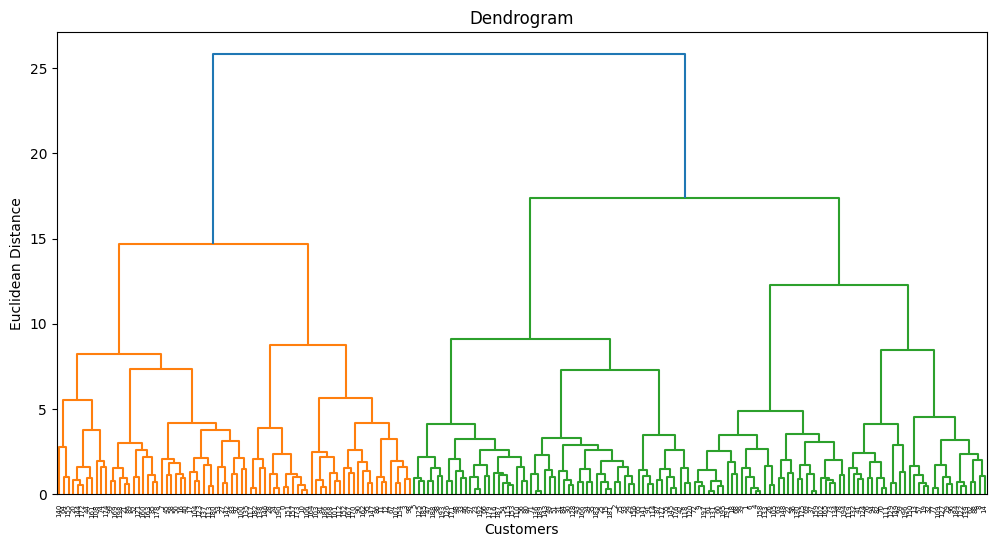

In [10]:
# Dendrogram to Determine Optimal Number of Clusters
plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(sch.linkage(scaled_features, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distance')
plt.show()

In [11]:
n_clusters = 3
hc = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
customer_data['Cluster'] = hc.fit_predict(scaled_features)

In [12]:
db_index = davies_bouldin_score(scaled_features, customer_data['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 1.559970755214448


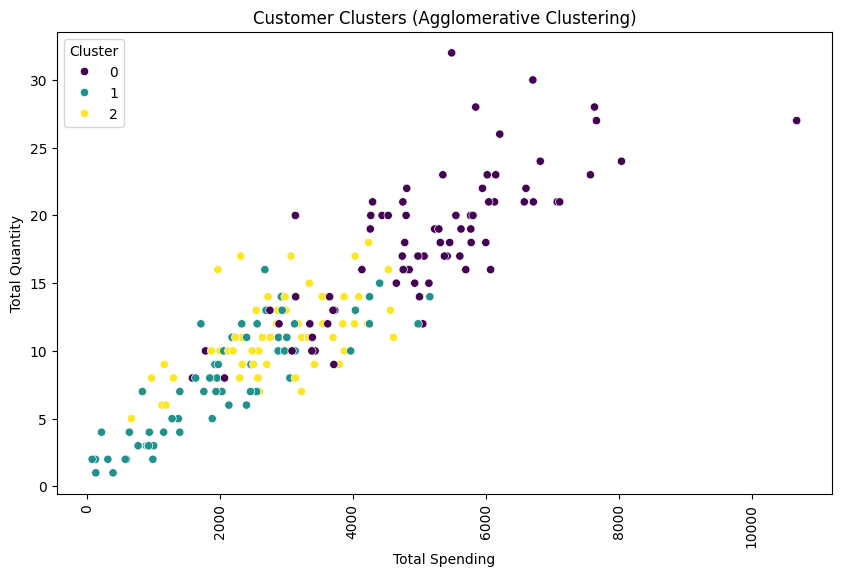

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_data['TotalValue'],
    y=customer_data['Quantity'],
    hue=customer_data['Cluster'],
    palette='viridis'
)
plt.title("Customer Clusters (Agglomerative Clustering)")
plt.xlabel("Total Spending")
plt.ylabel("Total Quantity")
plt.xticks(rotation=90)
plt.legend(title="Cluster")
plt.show()

In [14]:
cluster_summary = customer_data.groupby('Cluster').agg({
    'TotalValue': 'mean',
    'Quantity': 'mean',
    'ProductID': 'mean',
    'Category': 'mean',
    'Region': lambda x: x.mode()[0]
}).reset_index()

print(cluster_summary)

   Cluster   TotalValue   Quantity  ProductID  Category  Region
0        0  5088.134211  18.144737   6.605263  3.447368       3
1        1  2050.829206   7.746032   3.000000  1.888889       1
2        2  2901.585333  11.166667   4.716667  3.100000       2
